# HyperSpy EDS demo
Programming Courses, Electron Microscopy Spring School 2024

2024/03/06, Berlin

Dr. Siyuan Zhang, Max-Planck-Institut für Eisenforschung, siyuan.zhang@mpie.de

## 0. Load hyperspy module
For this demo, we are working with the latest version (2.0).

More on HyperSpy: https://github.com/hyperspy

In [1]:
%matplotlib qt
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
print(hs.__version__)

2.0


## 1. Load & plot EDS spectrum imaging data
HyperSpy provides many readers for electron microscopy data. Try to load your data later.

In [2]:
s = hs.load("EDS-IrO2+FTO.bcf", downsample=1, select_type='spectrum_image')
s

C:\Users\siyuan.zhang\Desktop\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<EDSTEMSpectrum, title: EDX, dimensions: (64, 64|4096)>

There is a lot of information and long list of metadata to explore in the dataset:

In [ ]:
s.plot()

In [ ]:
s.metadata

In [ ]:
s.axes_manager

Uncomment to export as raw data format:

In [ ]:
#s.save("EDS-IrO2+FTO.rpl")

## 2. Quantification (pixel-based)
We start by quantifying the EDS spectrum at individual pixels and learn why would not it work well.
### 2.1 Add or set elements for quantification

In [ ]:
s.sum().plot(True)

In [ ]:
s.add_elements(['O'])
s.add_lines(['O_Ka','Ir_Ma'])

In [ ]:
s.sum().plot(True)

In [3]:
s.set_elements(['Ir','Sn','F','O'])
s.set_lines(['Ir_La','Sn_La','F_Ka','O_Ka'])

Note the elements are stored in alphabetical order (regardless of the input order):

In [ ]:
s.metadata['Sample']

### 2.2 Set background and integration windows for signal integration
Start with an estimatation of the background and integration windows:

In [4]:
bw = s.estimate_background_windows(line_width=[4, 4])
iw = s.estimate_integration_windows(windows_width=3)

In [ ]:
s.sum().plot(True, background_windows=bw, integration_windows=iw)

In [ ]:
bw

Manual adjustment of background windows to model Bremsstrahlung: Each side needs to be at least 2 pixel wide!

In [5]:
bw[0] = [0.615, 0.63, 0.845, 0.855]
bw[2,0:2] = [0.31, 0.32]
bw[2,2:4] = bw[0,0:2]
bw[3] = [2.7, 2.9, 4.8, 5.0]
s.metadata['Sample']['elements'], bw

(['F', 'Ir', 'O', 'Sn'],
 array([[0.615     , 0.63      , 0.845     , 0.855     ],
        [8.38280489, 8.54120391, 9.80839609, 9.96679511],
        [0.31      , 0.32      , 0.615     , 0.63      ],
        [2.7       , 2.9       , 4.8       , 5.        ]]))

In [ ]:
s.sum().plot(True, background_windows=bw, integration_windows=iw)

Manual adjustment of integration windows

In [ ]:
iw

In [6]:
iw[0] = [0.64, 0.76]
iw[1][0] = 9
iw[2][0] = 0.45
iw[3][1] = 3.57
s.metadata['Sample']['elements'], iw

(['F', 'Ir', 'O', 'Sn'],
 [[0.64, 0.76],
  [9, 9.412398532192435],
  [0.45, 0.6132027462766589],
  [3.2883808736048166, 3.57]])

In [ ]:
s.sum().plot(True, background_windows=bw, integration_windows=iw)

Integration of signals within the selected windows:

In [7]:
s_I = s.get_lines_intensity(background_windows=bw, integration_windows=iw)
s_I

[<BaseSignal, title: X-ray line intensity of EDX: F_Ka at 0.68 keV, dimensions: (64, 64|)>,
 <BaseSignal, title: X-ray line intensity of EDX: Ir_La at 9.17 keV, dimensions: (64, 64|)>,
 <BaseSignal, title: X-ray line intensity of EDX: O_Ka at 0.52 keV, dimensions: (64, 64|)>,
 <BaseSignal, title: X-ray line intensity of EDX: Sn_La at 3.44 keV, dimensions: (64, 64|)>]

The Ir_La count map:

In [ ]:
s_I[1].plot()

The F_Ka count map shows many negative pixels due to background subtraction:

In [ ]:
s_I[0].plot()

The spatial distribution of SnO2 and IrO2 is apparent, the distribution of F is unclear. 

In [8]:
hs.plot.plot_images(s_I, cmap='hot', per_row=2, axes_decor=None, scalebar='all')

[<Axes: title={'center': 'F_Ka at 0.68 keV'}>,
 <Axes: title={'center': 'Ir_La at 9.17 keV'}>,
 <Axes: title={'center': 'O_Ka at 0.52 keV'}>,
 <Axes: title={'center': 'Sn_La at 3.44 keV'}>]

### 2.3 Cliff-Lorimer quantification
Cliff-Lorimer k_factors were read out from listed values for SuperX EDS detector, 300 keV beam energy.

In [9]:
k_factors = np.array([1.128, 4.82, 1.16, 3.358])
s.metadata['Sample']['elements'], k_factors

(['F', 'Ir', 'O', 'Sn'], array([1.128, 4.82 , 1.16 , 3.358]))

In [10]:
s_quant = s.quantification(s_I, 'CL', factors=k_factors)

[                                        ] | 0% Completed | 967.40 us

C:\Users\siyuan.zhang\Desktop\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\exspy\misc\eds\utils.py:516: RuntimeWarning: divide by zero encountered in scalar divide
  (intensities[ref_index] * absorption_correction[ref_index])


[########################################] | 100% Completed | 104.71 ms


Due to the negative counts of F and O, the quantification does not make sense:

In [11]:
hs.plot.plot_images(s_quant, cmap='hot', per_row=2, axes_decor=None, scalebar='all')

[<Axes: title={'center': 'F'}>,
 <Axes: title={'center': 'Ir'}>,
 <Axes: title={'center': 'O'}>,
 <Axes: title={'center': 'Sn'}>]

Hence, the quantification is only performed on Ir and Sn:

In [ ]:
s_quant_metal = s.quantification([s_I[1],s_I[3]], 'CL', factors=k_factors[[1,3]])

In [ ]:
hs.plot.plot_images(s_quant_metal, cmap='hot', per_row=2, axes_decor=None, scalebar='all')

## 3 Multivariate statistical analysis
For STEM-EDS spectrum imaging, the dwell time at indivudal pixel is often too short to provide sufficient statistics. Nevertheless, if many pixels share similar EDS (e.g. they originate from areas of the same phase/composition), the statistics would be improved by integration. Multivariate statistical analysis can be applied to exploit such redundancy in the dataset, which can separate phases (compositions) with statistics above the noise background.

In [12]:
s.change_dtype('float')

### 3.1 Principal component analysis (PCA)
Singular value decomposition (SVD) is a common algorithm to perform PCA, listing the principal components of the dataset in decreasing importance (statistical correlation)

In [ ]:
s.decomposition(algorithm = 'SVD')

The explained variance ratio (scree) plot indicates the number of principal components (above the noise level):

In [ ]:
s.plot_explained_variance_ratio()

The decomposition factors correspond to the components of the EDS spectrum:
Here the 4th component (component_3 in red) appears like noise.

In [ ]:
s.plot_decomposition_factors(comp_ids=4)

The decomposition loadings show the weighting of individual spectral components at each pixel. 
We further confirm that component_3 is dominated by variation of a single pixel (likely an X-ray spike there).

In [ ]:
s.plot_decomposition_loadings(comp_ids=4, per_row=2)

We observe that a lot of variance comes from the 0-peak in the EDS spectrum and cuts it off the analysis. We also cut off signals beyond 10 keV, as there are no longer peaks for quantification.

The signal axis in Hpyerspy is called by .isig[a,b]. Use float numbers for a range of values, use integers for a range of index.

In [ ]:
s.isig[0.35:10.].plot()

In [13]:
s.crop_signal(0.35,10.)

In [ ]:
s.sum().plot(True)

If necessary to boost the statistical significance of individual signals, we could bin the signals along x, y, or the energy axis:

In [ ]:
#s.rebin(scale = (1,1,2))

In [14]:
s.decomposition(algorithm = 'SVD')

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


In [15]:
s.plot_explained_variance_ratio()

<Axes: title={'center': 'EDX\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

Now we only observe 2 principal components, as confirmed by the noisy features of the third component (component_2)

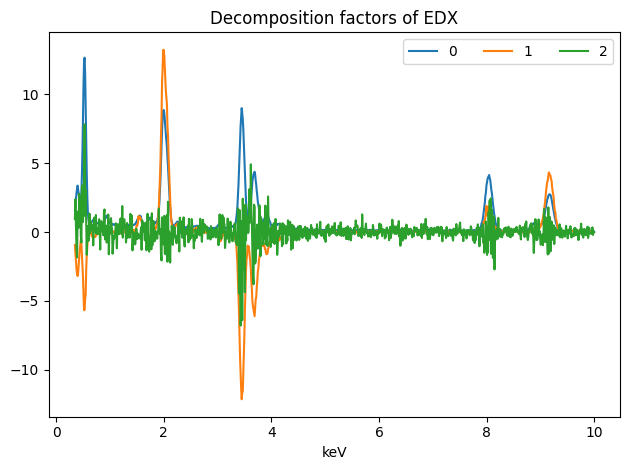

In [16]:
s.plot_decomposition_factors(comp_ids=3)

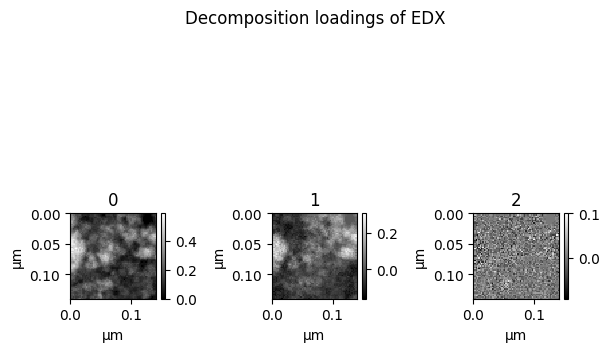

In [17]:
s.plot_decomposition_loadings(comp_ids=3)

### 3.2 Non-negative Matrix Factorization (NMF)
PCA decomposition gives negative counts in spectral components and weighting, making component-based quantification (https://doi.org/10.1093/jmicro/dfx091) more challenging.

NMF decomposition returns non-negative numbers in spectral components and weighting. A preceeding PCA is necessary to determine the number of principal components (nComp). Here we set nComp as 2, according to the PCA scree plot.

In [18]:
nComp = 2
s.decomposition(algorithm = 'NMF', output_dimension = nComp)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=2
  centre=None
scikit-learn estimator:
NMF(n_components=2)


C:\Users\siyuan.zhang\Desktop\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Now we get non_negative spectral components (factors) and weightings (loadings). The spectral components appear much like physical EDS spectra.

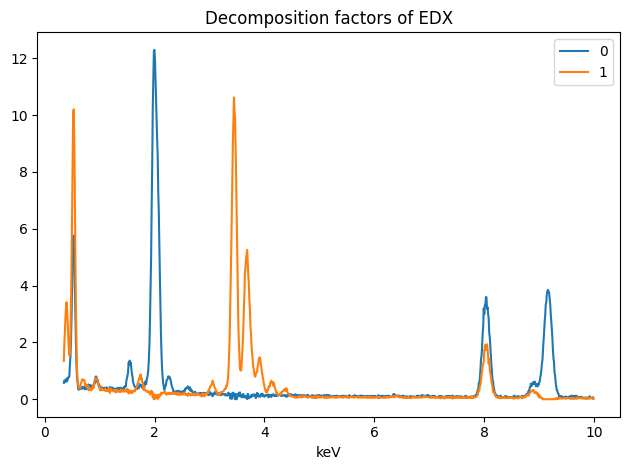

In [19]:
s.plot_decomposition_factors()

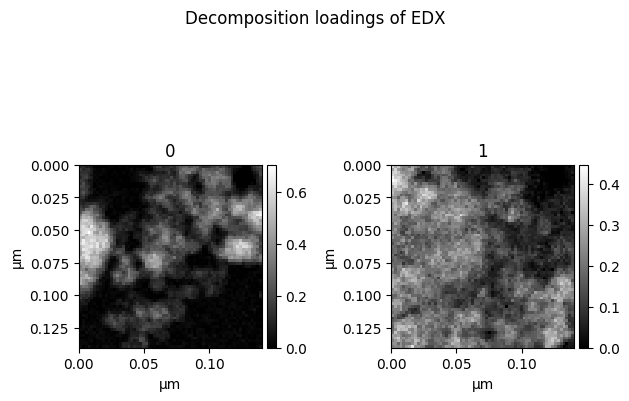

In [20]:
s.plot_decomposition_loadings()

## 4 Component-based quantification
The philosophy of component-based quantification is described in https://doi.org/10.1093/jmicro/dfx091

Here we benefit the dimension reduction from multivariate statistical analysis, more specifically, NMF as shown above. Instead of quantifying thousands of spectra at each pixel (64*64 in this case), we only need to supervise the quantification of a handful of spectral components (2 in this case).
### 4.1 Quantification of individual spectral component
In hyperspy, use the navigation axis .inav to call the spectral components:

In [21]:
s0 = s.get_decomposition_factors().inav[0]
s1 = s.get_decomposition_factors().inav[1]

Now we supervise the quantification of each spectral component. 
The first component s0 contains Ir_La and O_Ka, but not Sn_La or F_Ka.

In [ ]:
s0.plot(True)

In [22]:
s0.set_elements(['Ir','O'])
s0.set_lines(['Ir_La','O_Ka'])
s0.metadata['Sample']

├── elements = ['Ir', 'O']
└── xray_lines = ['Ir_La', 'O_Ka']

In [23]:
bw0 = s0.estimate_background_windows(line_width=[4, 4])
iw0 = s0.estimate_integration_windows(windows_width=3)

In [ ]:
s0.plot(True, background_windows=bw0, integration_windows=iw0)

In [ ]:
s0.metadata['Sample']['elements'], bw0, iw0

In [24]:
bw0[1,:] = [0.35, 0.4, 0.6, 0.7]
s0.metadata['Sample']['elements'], bw0

(['Ir', 'O'],
 array([[8.38280489, 8.54120391, 9.80839609, 9.96679511],
        [0.35      , 0.4       , 0.6       , 0.7       ]]))

In [25]:
iw0[0][0] = 9
iw0[1] = [0.45, 0.6]
s0.metadata['Sample']['elements'], iw0

(['Ir', 'O'], [[9, 9.412398532192435], [0.45, 0.6]])

In [ ]:
s0.plot(True, background_windows=bw0, integration_windows=iw0)

In [26]:
s0_I = s0.get_lines_intensity(background_windows=bw0, integration_windows=iw0)
s0_I

[<BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: Ir_La at 9.17 keV, dimensions: (1|)>,
 <BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: O_Ka at 0.52 keV, dimensions: (1|)>]

In [27]:
s0.metadata['Sample']['elements'], s0_I[0].data[0], s0_I[1].data[0]

(['Ir', 'O'], 504.98956853385215, 37.81033883008036)

In [28]:
s0_quant = s0.quantification(s0_I, 'CL', factors=k_factors[[1,2]])

[########################################] | 100% Completed | 104.18 ms


In [29]:
s0.metadata['Sample']['elements'], s0_quant[0].data[0], s0_quant[1].data[0]

(['Ir', 'O'], 82.2040752813031, 17.79592471869689)

The second component s1 contains Sn_La, O_Ka and F_Ka, but not Ir_La. Together with the absence of F_Ka in s0 (IrO2 phase), this is strong evidence for F only present in the SnO2 phase!

In [ ]:
s1.plot(True)

In [30]:
s1.set_elements(['F','Sn','O'])
s1.set_lines(['F_Ka','Sn_La','O_Ka'])
s1.metadata['Sample']

├── elements = ['F', 'O', 'Sn']
└── xray_lines = ['F_Ka', 'O_Ka', 'Sn_La']

In [31]:
bw1 = s1.estimate_background_windows(line_width=[4,4])
iw1 = s1.estimate_integration_windows(windows_width=3)

In [ ]:
s1.plot(True, background_windows=bw1, integration_windows=iw1)

In [32]:
bw1[0,:] = [0.62, 0.64, 0.8, 0.85]
bw1[1,:] = [0.45, 0.46, 0.62, 0.64]
bw1[2,:] = [2.5, 2.9, 5, 5.5]
s1.metadata['Sample']['elements'], bw1

(['F', 'O', 'Sn'],
 array([[0.62, 0.64, 0.8 , 0.85],
        [0.45, 0.46, 0.62, 0.64],
        [2.5 , 2.9 , 5.  , 5.5 ]]))

In [33]:
iw1[0] = [0.65, 0.75]
iw1[1] = [0.45, 0.6]
iw1[2][1] = 3.57
s1.metadata['Sample']['elements'], iw1

(['F', 'O', 'Sn'], [[0.65, 0.75], [0.45, 0.6], [3.2883808736048166, 3.57]])

In [34]:
s1_I = s1.get_lines_intensity(background_windows=bw1, integration_windows=iw1)
s1_I

[<BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: F_Ka at 0.68 keV, dimensions: (1|)>,
 <BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: O_Ka at 0.52 keV, dimensions: (1|)>,
 <BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: Sn_La at 3.44 keV, dimensions: (1|)>]

In [35]:
s1.metadata['Sample']['elements'], s1_I[0].data[0], s1_I[1].data[0], s1_I[2].data[0]

(['F', 'O', 'Sn'], 2.3501323389783235, 64.81950826257884, 119.31996493532122)

In [36]:
s1_quant = s1.quantification(s1_I, 'CL', factors=k_factors[[0,2,3]])

[########################################] | 100% Completed | 103.78 ms


In [37]:
s1.metadata['Sample']['elements'], s1_quant[0].data[0], s1_quant[1].data[0], s1_quant[2].data[0]

(['F', 'O', 'Sn'], 1.698671939934493, 57.211748373755526, 41.08957968630998)

### 4.2 Reconstruction from component-based quantification to pixel-based
Now we reconstruct the quantification results from 2 spectral components (integrated intensity: s0_I, s1_I) back to individual pixels using the weighting matrix. Also see Equation 2 in https://doi.org/10.1093/jmicro/dfx091.

In [38]:
s0_I, s1_I

([<BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: Ir_La at 9.17 keV, dimensions: (1|)>,
  <BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: O_Ka at 0.52 keV, dimensions: (1|)>],
 [<BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: F_Ka at 0.68 keV, dimensions: (1|)>,
  <BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: O_Ka at 0.52 keV, dimensions: (1|)>,
  <BaseSignal, title: X-ray line intensity of Decomposition factors of EDX: Sn_La at 3.44 keV, dimensions: (1|)>])

In [39]:
s.metadata['Sample']['elements'], k_factors

(['F', 'Ir', 'O', 'Sn'], array([1.128, 4.82 , 1.16 , 3.358]))

Note that not all the elements were detected in every spectral component: Ir and O in s0; F, O, and Sn in s1. We need to treat the integrated intensity of the missing elements as 0.

In [40]:
nElement = k_factors.size
intensity = np.zeros((nElement,nComp))
intensity

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

Ir and O intensity from s0 is included in the first column (column_0) as their corresponding positions from the element list.

In [41]:
intensity[:,0] = [0, s0_I[0].data[0], s0_I[1].data[0], 0]
intensity

array([[  0.        ,   0.        ],
       [504.98956853,   0.        ],
       [ 37.81033883,   0.        ],
       [  0.        ,   0.        ]])

F, O, and Sn intensity from s1 is included in the second column (column_1) as their corresponding positions from the element list.

In [42]:
intensity[:,1] = [s1_I[0].data[0], 0, s1_I[1].data[0], s1_I[2].data[0]]
intensity

array([[  0.        ,   2.35013234],
       [504.98956853,   0.        ],
       [ 37.81033883,  64.81950826],
       [  0.        , 119.31996494]])

The weighting matrix is accessed from the previous NMF decomposition:

In [43]:
weight = s.get_decomposition_loadings()
weight

<BaseSignal, title: Decomposition loadings of EDX, dimensions: (2|64, 64)>

Here comes the implementation for Equation 2 in https://doi.org/10.1093/jmicro/dfx091.

In [44]:
signal_I = s.get_lines_intensity()
element_I = np.zeros((nElement, weight.data[0].shape[0], weight.data[0].shape[1]))

for iElement in range(0,nElement):
    element_I[iElement] = np.zeros((weight.data[0].shape))
    for iComp in range(0,nComp):
        element_I[iElement] = element_I[iElement] + intensity[iElement][iComp]*weight.data[iComp]
    signal_I[iElement].data = element_I[iElement]

In [45]:
hs.plot.plot_images(signal_I, cmap='hot', per_row=2, axes_decor=None, scalebar='all')

[<Axes: title={'center': 'F_Ka at 0.68 keV'}>,
 <Axes: title={'center': 'Ir_La at 9.17 keV'}>,
 <Axes: title={'center': 'O_Ka at 0.52 keV'}>,
 <Axes: title={'center': 'Sn_La at 3.44 keV'}>]

In [46]:
signal_quant = s.quantification(signal_I, 'CL', factors=k_factors)

[                                        ] | 0% Completed | 701.20 us

C:\Users\siyuan.zhang\Desktop\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\exspy\misc\eds\utils.py:516: RuntimeWarning: divide by zero encountered in scalar divide
  (intensities[ref_index] * absorption_correction[ref_index])


[########################################] | 100% Completed | 103.85 ms


C:\Users\siyuan.zhang\Desktop\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\exspy\misc\material.py:77: RuntimeWarning: invalid value encountered in divide
  atomic_percent[i] /= sum_weight


In [47]:
hs.plot.plot_images(signal_quant, cmap='hot', per_row=2, axes_decor=None, scalebar='all')

[<Axes: title={'center': 'F'}>,
 <Axes: title={'center': 'Ir'}>,
 <Axes: title={'center': 'O'}>,
 <Axes: title={'center': 'Sn'}>]